# MarlimR3D - Meshes and Fields

**A big THANK YOU to [@Bane](https://github.com/banesullivan) for the help with PyVista to plot the tetrahedra mesh!**

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook

## Load survey info

In [3]:
data = xr.load_dataset('marlim_survey.nc', engine='h5netcdf')

## Load results from modellers

### Tensor Mesh: emg3d

In [4]:
egd = emg3d.load('results/emg3d_meshesfields.h5')
mesh_emg3d = egd['mesh']
efield_emg3d_fx = egd['fx']
efield_emg3d_fy = egd['fy']

mesh_emg3d

Data loaded from «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_meshesfields.h5»
[emg3d v0.12.0 (format 0.12.0) on 2020-09-29T17:06:11.402099].


TensorMesh: 1,966,080 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    192    327,426.00    453,624.00    100.00 17,300.00    1.50
   y     80  7,464,458.23  7,570,039.77    100.00 16,345.65    1.48
   z    128    -56,648.00     83,814.00     20.00 28,155.00    1.50

### OcTree Mesh: SimPEG

In [5]:
# Load mesh
mesh_simpeg = discretize.TreeMesh.readUBC("results/simpeg_marlim_mesh.txt")

# Load fields
simpeg_e = np.load("results/simpeg_marlim_fields.npy")
simpeg_e = simpeg_e.reshape(mesh_simpeg.nE, len(data.freqs), order="F")

mesh_simpeg

OcTreeMesh,0.00% filled
Level,Number of cells
1,2
2,24
3,160
4,212
5,263
6,504
7,1006
8,2579
9,11032


### Tetrahedral Mesh: custEM

In [6]:
path = "./results/custEM_mesh_and_fields/"
mesh = pv.read(path+"f_1.0_Domains000000.pvtu")
f_re = pv.read(path+"f_1.0_E_t_real_cg000000.pvtu")
f_im = pv.read(path+"f_1.0_E_t_imag_cg000000.pvtu")

def create_cartesian_slice_for_mpl(mesh, normal='x', origin=None, scalars=None):
    """This only works if the slice is to be along a cartesian axes
    
    See https://github.com/pyvista/pyvista-support/issues/70

    normal is a str of the axes norma to slice (x, y, or z)
    origin is location of slice. 
    scalars is name of array to use.
    """
    data = mesh.slice(normal=normal, origin=origin, generate_triangles=True)
    assert data.is_all_triangles()

    # Grab data for Matplotlib
    x = data.points
    tri = data.faces.reshape((-1, 4))[:, 1:]
    if scalars is None:
        u = data.active_scalars
    else:
        u = data[scalars]
    
    if normal == 'x':
        a, b = x[:,1], x[:,2] # YZ
    elif normal == 'y':
        a, b = x[:,0], x[:,2] # XZ
    elif normal == 'z':
        a, b = x[:,0], x[:,1] # XY
    else:
        raise ValueError("Normal must be 'x', 'y', or 'z' to align with cartesian axes.")
    
    return a, b, tri, u


# Broadside => -1km from source in y-direction.
xtri, ytri, tri, _ = create_cartesian_slice_for_mpl(mesh, 'y', (0, -1000, 0))
_, _, _, tri_re = create_cartesian_slice_for_mpl(f_re, 'y', (0, -1000, 0))
_, _, _, tri_im = create_cartesian_slice_for_mpl(f_im, 'y', (0, -1000, 0))

xtri += 390275

def crinkle_slice(mesh, *args, **kwargs):
    """Returns crinkled and normal slice. Same arguments as slice filter"""
    mesh['cell_ids'] = np.arange(0, mesh.n_cells, dtype=int)
    slc = mesh.slice(normal='y', *args, **kwargs)
    cut = mesh.extract_cells(np.unique(slc['cell_ids']))
    return cut, slc

# Get crinkled slice
cnk, slc = crinkle_slice(mesh, generate_triangles=False)

# Take a screenshot in PyVista
p = pv.Plotter(off_screen=True, notebook=False)
p.enable_parallel_projection()
p.add_mesh(cnk, color='red')
p.camera_position = 'xz'
img = p.screenshot(return_img=True, transparent_background=True, window_size=(5000, 5000))
p.close()

points = np.argwhere(img[:, :, 3] > 0.0)
hull = ConvexHull(points)

boundary = points[hull.vertices]
# Close the loop
boundary = np.append(boundary, boundary[0][None], axis=0)
ix = boundary[:,0]
iy = boundary[:,1]

pad = 10
texture = img[np.min(ix)+pad:np.max(ix)-pad, np.min(iy)+pad:np.max(iy)-pad, :3]  @ [0.299, 0.587, 0.114]

bounds = np.r_[mesh.bounds[:2], mesh.bounds[4:6]]
bounds[:2] += 390275
    
mesh

UnstructuredGrid (0x7f1fbf18ee80)
  N Cells:	303010
  N Points:	53986
  X Bounds:	-2.508e+04, 2.508e+04
  Y Bounds:	-2.508e+04, 2.508e+04
  Z Bounds:	-2.508e+04, 2.508e+04
  N Arrays:	4

## Figures

<IPython.core.display.Javascript object>


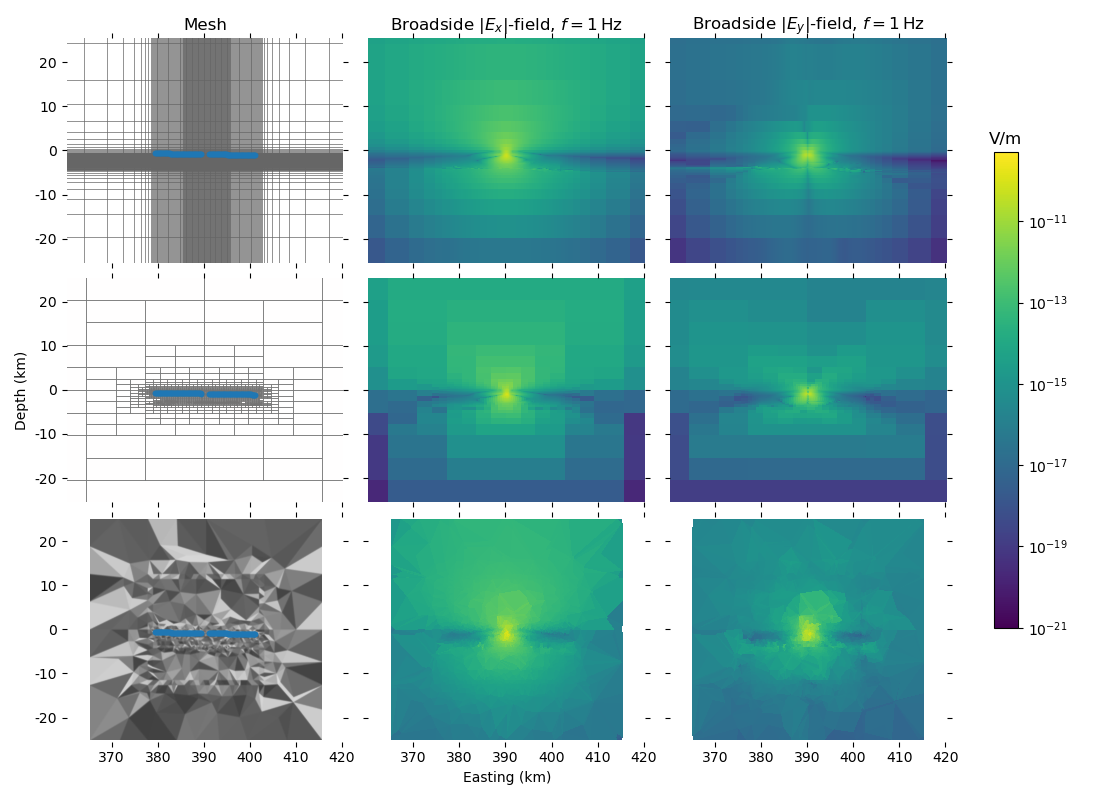

Vertical exaggeration: 1.0


<IPython.core.display.Javascript object>


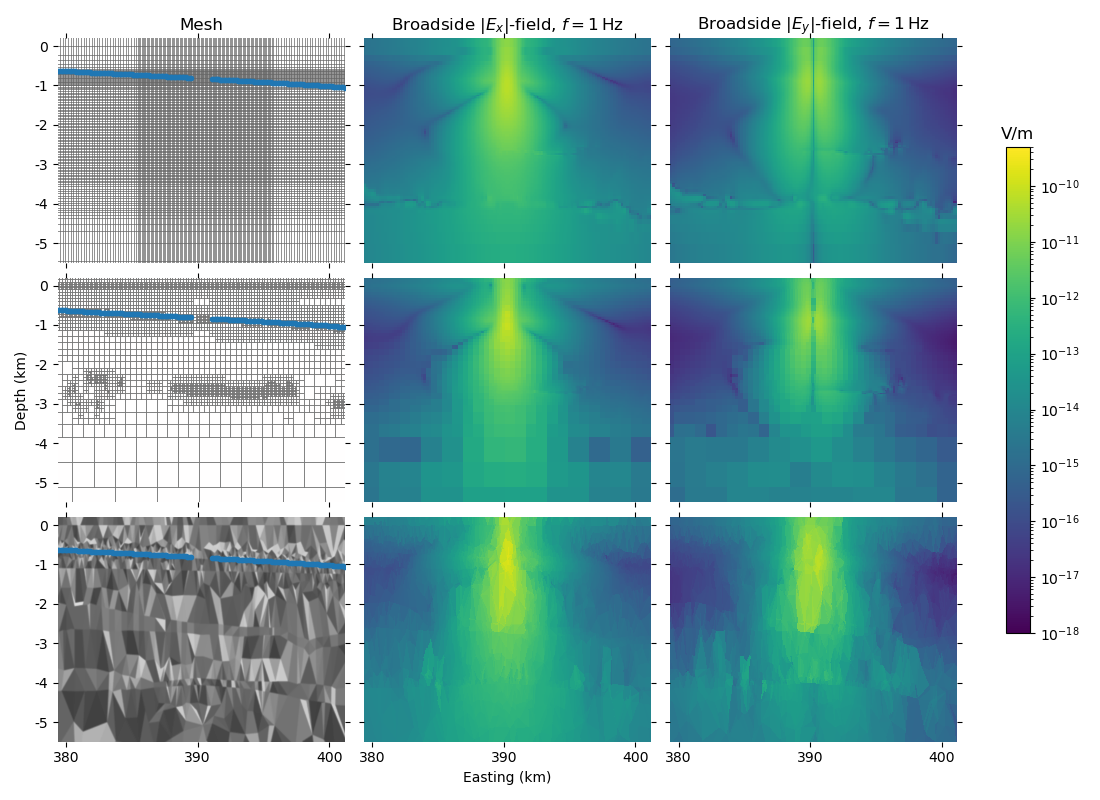

Vertical exaggeration: 3.0


In [7]:
# Define some appearances here, so we can easily change them for all
lc = '0.4'
lw = 0.5

for case in ['big', 'survey']:

    # Min/max for pcolormesh, depending on case.
    if case == 'big':
        vnorms = {'vmin': 1e-21, 'vmax': 5e-10}
    else:
        vnorms = {'vmin': 1e-18, 'vmax': 5e-10}

        
    # Min/max of all meshes.
    xmin = min(mesh_emg3d.vectorNx.min(), mesh_simpeg.vectorNx.min())
    xmax = max(mesh_emg3d.vectorNx.max(), mesh_simpeg.vectorNx.max())
    zmin = min(mesh_emg3d.vectorNz.min(), mesh_simpeg.vectorNz.min())
    zmax = max(mesh_emg3d.vectorNz.max(), mesh_simpeg.vectorNz.max())

    
    # Initiate figure (axes shared)
    fig, axs = plt.subplots(3, 3, figsize=(11, 8), sharey=True, sharex=True)
    ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = axs


    # # # (A) TensorMesh (ax1-ax3) # # #

    # Get dimension from mesh
    xmin_A, xmax_A = mesh_emg3d.vectorNx[0], mesh_emg3d.vectorNx[-1]
    zmin_A, zmax_A = mesh_emg3d.vectorNz[0], mesh_emg3d.vectorNz[-1]
    
    # Plot Mesh
    ax1.vlines(mesh_emg3d.vectorNx, zmin_A, zmax_A, colors=lc, lw=lw)
    ax1.hlines(mesh_emg3d.vectorNz, xmin_A, xmax_A, colors=lc, lw=lw)

    # Plot Ex-field
    for ax, field in zip([ax2, ax3], [efield_emg3d_fx, efield_emg3d_fy]):
        cb = ax.pcolormesh(mesh_emg3d.vectorNx, mesh_emg3d.vectorNz,
                           abs(field.T), rasterized=True, 
                           norm=LogNorm(**vnorms))


    # # # (B) OcTreeMesh (ax4-ax6) # # #

    # yind = 508 # Inline
    yind = 498 # Broadside
    
    # Plot Mesh
    mesh_simpeg.plotSlice(
        np.zeros(mesh_simpeg.nC), grid=True, normal="Y", ax=ax4,
        grid_opts={"color": lc},
        pcolor_opts={"cmap": "bwr", "vmin": -1, "vmax": 1}
    )
    
    # Plot Ex-field
    mesh_simpeg.plotSlice(
        np.abs(mesh_simpeg.aveEx2CC * simpeg_e[:mesh_simpeg.nEx, -1]), 
        normal="Y", ind=yind, ax=ax5,
        pcolor_opts={"norm": LogNorm(**vnorms)}
    )
    
    # Plot Ey-field
    mesh_simpeg.plotSlice(
        np.abs(mesh_simpeg.aveEy2CC * simpeg_e[mesh_simpeg.nEx:mesh_simpeg.nEx+mesh_simpeg.nEy, -1]), 
        normal="Y", ind=yind, ax=ax6,
        pcolor_opts={"norm": LogNorm(**vnorms)}
    )

    # Undo/modify some discretize.plotSlice particularities:
    # Switch-off annotations; rasterize; line-width
    for ax in [ax4, ax5, ax6]:
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_rasterized(True)
    ax4.collections[0].set_linewidth(lw)


    # # # (C) TetrahedralMesh (ax7-ax9) # # #
    slen = 10  # Source length of 10 m
    
    # Plot Mesh
    # ax7.triplot(xtri, ytri, tri, color=lc, lw=lw)
    vrange = (texture.max()-texture.min())/3
    ax7.imshow(texture, aspect='auto', interpolation='bicubic',
               vmin=texture.min()-vrange, vmax=texture.max()+vrange,
               cmap='Greys', extent=bounds)

    # Plot Ex-field
    ax8.tripcolor(xtri, ytri, tri, abs(tri_re[:, 0]+1j*tri_im[:, 0])/slen,
                  rasterized=True, norm=LogNorm(**vnorms))

    # Plot Ey-field
    ax9.tripcolor(xtri, ytri, tri, abs(tri_re[:, 1]+1j*tri_im[:, 1])/slen,
                  rasterized=True, norm=LogNorm(**vnorms))

    # # # FINALIZE # # #
    
    # Plot survey over meshes.
    for ax in axs[:, 0]:
        ax.plot(data.src_x[::2], data.data_bs.attrs['src_z'], '.')
    
    # Set x- and y-limits
    if case == 'big':
        ax1.set_xlim([data.rec_x-30000, data.rec_x+30000])
        ax1.set_ylim([-25500, 25500])
    else:
        ax1.set_xlim([data.src_x[0], data.src_x[-1]])
        ax1.set_ylim([-5500, 200])
        
    # Titles and labels.
    ax1.set_title('Mesh')
    ax2.set_title('Broadside $|E_x|$-field, $f=1\,$Hz')
    ax3.set_title('Broadside $|E_y|$-field, $f=1\,$Hz')
    ax8.set_xlabel('Easting (km)')
    ax4.set_ylabel('Depth (km)')

    # Turn spines off, but ticks on all sides.
    for ax in axs.ravel():
        [ax.spines[k].set_visible(False) for k in ax.spines.keys()]
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
    
    # Reduce number of ticks.
    if case == 'big':
        ax7.set_xticks(1000*np.array([370, 380, 390, 400, 410, 420]))
        ax7.set_xticklabels(['370', '380', '390', '400', '410', '420'])
        ax1.set_yticks(1000*np.array([-20, -10, 0, 10, 20]))
        ax1.set_yticklabels(['-20', '-10', '0', '10', '20'])
    else:
        ax7.set_xticks(1000*np.array([380, 390, 400]))
        ax7.set_xticklabels(['380', '390', '400'])
        ax1.set_yticks(-1000*np.arange(6)[::-1])
        ax1.set_yticklabels(['-5', '-4', '-3', '-2', '-1', '0'])

    # Make tight, leave space for colorbar.
    fig.tight_layout(rect=[0, 0, 0.95, 1])

    # Colorbar.
    c = fig.colorbar(cb, ax=axs, fraction=0.025)
    c.ax.set_title('V/m')

    # Print exaggeration.
    fw, fh = ax1.get_figure().get_size_inches()
    _, _, aw, ah = ax1.get_position().bounds
    ratio = (fh * ah) / (fw * aw)
    ratio /= np.diff(ax1.get_ylim()) / np.diff(ax1.get_xlim())
    print(f"Vertical exaggeration: {ratio[0]:.1f}")

    # Save and show.
    fig.savefig(f'../manuscript/figures/results-marlim_{case}.pdf', bbox_inches='tight')
    fig.show()

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Oct 12 18:45:56 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.3 (default, Jul  2 2020, 16:21:59)  [GCC 7.3.0]

             numpy : 1.18.5
             scipy : 1.5.0
             numba : 0.50.1
             emg3d : 0.13.1.dev6+gd263c3c.d20201009
           empymod : 2.0.3
            xarray : 0.16.1
        discretize : 0.5.1
              h5py : 2.10.0
        matplotlib : 3.2.2
              tqdm : 4.47.0
           IPython : 7.16.1

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------